In [ ]:
!pip install gymnasium
!pip install swig
!apt install xvfb
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# gymnasium imports
import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo

# video imports
import glob
import uuid
import io
import base64
from IPython.display import HTML
# from IPython import display as ipythondisplay

# ml imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# plot imports
import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display as ipythondisplay


# utility imports
import math
import random
from itertools import count
from collections import namedtuple, deque

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

folder_name = f"./video/CartPole-v1/{uuid.uuid4()}"
wrapper_env = RecordVideo(env, folder_name, disable_logger=True)

observation, info = env.reset()

for _ in range(1000):
    action = wrapper_env.action_space.sample()
    observation, reward, terminated, truncated, info = wrapper_env.step(action)

    if terminated or truncated:
        observation, info = wrapper_env.reset()

wrapper_env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


In [ ]:
def show_video(folder_name, episode='last'):
    mp4list = glob.glob(f'{folder_name}/*.mp4')
    if len(mp4list) > 0:
        sorted_mp4list = sorted(mp4list, key=lambda x: int(x.split('-')[-1].split('.')[0]))
        if episode == 'last':
            mp4 = sorted_mp4list[-1]
        elif episode == 'first':
            mp4 = sorted_mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [ ]:
show_video(folder_name)

Episode End
The episode ends if any one of the following occurs:

Termination: Pole Angle is greater than ±12°

Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

Truncation: Episode length is greater than 500 (200 for v0)

In [ ]:
folder_name

'./video/CartPole-v1/6a4cc117-ee18-4653-832b-ac909e2c3bf4'

In [ ]:
import os

In [ ]:
current_directory = os.getcwd()
current_directory

'/content'

In [ ]:
os.listdir()

['.config', 'video', 'sample_data']

In [ ]:
os.listdir(os.path.join('video', 'CartPole-v1'))

['a26eea92-14af-4e13-a5b4-896c736f8b46',
 '3c8a8f41-2d98-4363-ac65-f83ebd869833',
 'b1a987cd-c911-4622-9c93-f1c217c6f1e1',
 '39997ea0-893e-421d-b0d2-0a24211eed0b',
 '16c8a359-a4fc-4015-b003-d606ee06735f',
 '67d30b96-7f5d-4d74-b8c4-6ffca353bb1e',
 '6a4cc117-ee18-4653-832b-ac909e2c3bf4']

In [ ]:
mp4list = glob.glob(f'{folder_name}/*.mp4')
mp4list

['./video/CartPole-v1/6a4cc117-ee18-4653-832b-ac909e2c3bf4/rl-video-episode-27.mp4',
 './video/CartPole-v1/6a4cc117-ee18-4653-832b-ac909e2c3bf4/rl-video-episode-8.mp4',
 './video/CartPole-v1/6a4cc117-ee18-4653-832b-ac909e2c3bf4/rl-video-episode-1.mp4',
 './video/CartPole-v1/6a4cc117-ee18-4653-832b-ac909e2c3bf4/rl-video-episode-0.mp4']

DQN

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            ipythondisplay.display(plt.gcf())
            ipythondisplay.clear_output(wait=True)
        else:
            ipythondisplay.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


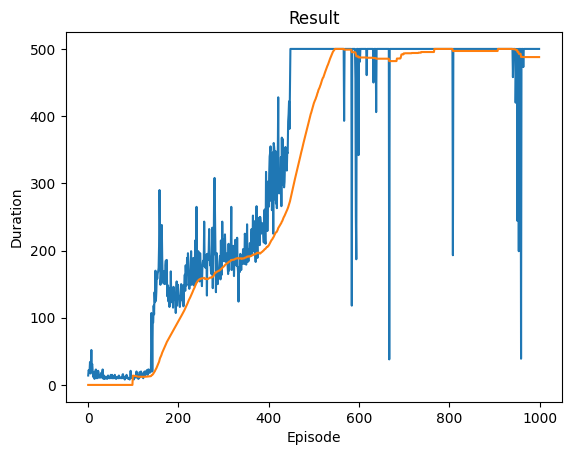

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the wrapper_environment and get its state
    state, info = wrapper_env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = wrapper_env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
show_video(folder_name)

In [ ]:
os.listdir(folder_name)

['rl-video-episode-125.mp4',
 'rl-video-episode-27.mp4',
 'rl-video-episode-8.meta.json',
 'rl-video-episode-8.mp4',
 'rl-video-episode-64.meta.json',
 'rl-video-episode-1.mp4',
 'rl-video-episode-216.mp4',
 'rl-video-episode-27.meta.json',
 'rl-video-episode-512.meta.json',
 'rl-video-episode-0.meta.json',
 'rl-video-episode-729.mp4',
 'rl-video-episode-1000.mp4',
 'rl-video-episode-0.mp4',
 'rl-video-episode-512.mp4',
 'rl-video-episode-216.meta.json',
 'rl-video-episode-125.meta.json',
 'rl-video-episode-343.mp4',
 'rl-video-episode-729.meta.json',
 'rl-video-episode-64.mp4',
 'rl-video-episode-343.meta.json',
 'rl-video-episode-1000.meta.json',
 'rl-video-episode-1.meta.json']

In [ ]:
def show_video(folder_name, episode='last'):
    mp4list = glob.glob(f'{folder_name}/*.mp4')
    if len(mp4list) > 0:
        sorted_mp4list = sorted(mp4list, key=lambda x: int(x.split('-')[-1].split('.')[0]))
        if episode == 'last':
            mp4 = sorted_mp4list[-1]
        elif episode == 'first':
            mp4 = sorted_mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [ ]:
show_video(folder_name)